## Plotting roofline model
Key takeaways: naive matmul implementations are well below theoretical bounds. This suggests improvements in both memory and computation strategies are needed. Some possible improvements could be:
- Leverage shared memory (redundant memory accesses with the naive approach)
- Memory access patterns (writing and reading from consecutive memory addresses)em 2

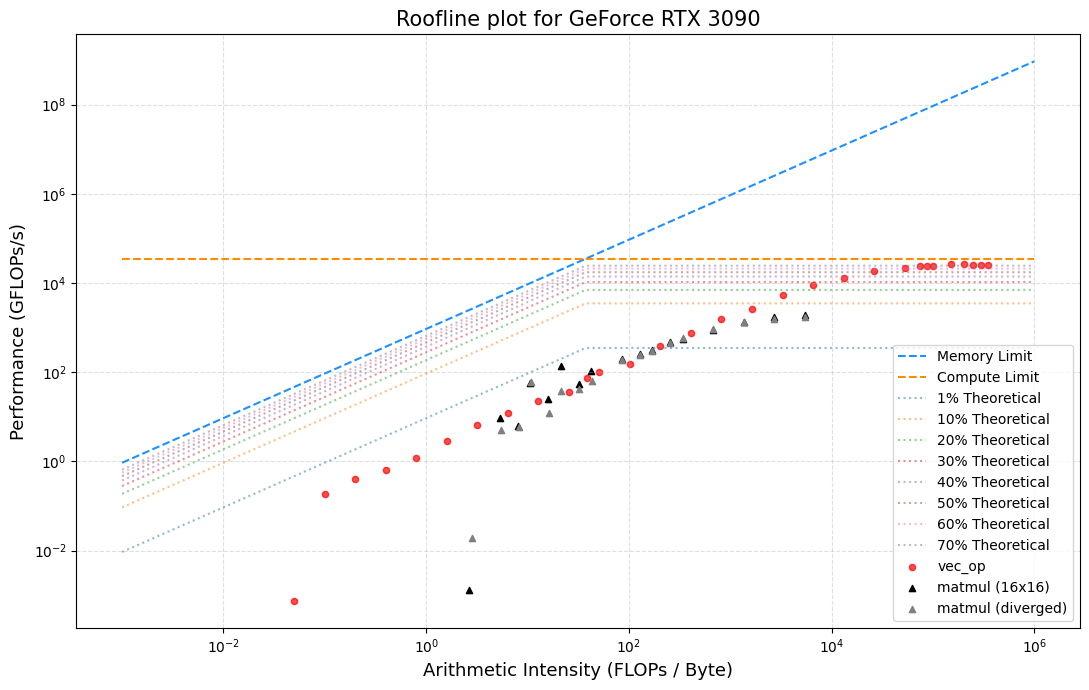

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# -----------------------------
# Load Data
# -----------------------------
vec_df = pd.read_csv("vec_op_byte_sweep33.csv")
matmul_df = pd.read_csv("roofline_results.csv")         # 16x16 threads
diverged_df = pd.read_csv("roofline_results2.csv")      # Warp-diverged
matmul_8x8_df = pd.read_csv("roofline_results3.csv")     # 8x8 threads
matmul_32x32_df = pd.read_csv("roofline_results4.csv")   # 32x32 threads
mem_df = pd.read_csv("memory_stress_extended.csv")

# Compute arithmetic intensity
for df in [matmul_df, diverged_df, matmul_8x8_df, matmul_32x32_df]:
    df["intensity"] = df["flop_per_byte"]

# -----------------------------
# Set Theoretical Limits
# -----------------------------
peak_gflops = 35000
peak_bandwidth = 935

intensity_range = np.logspace(-3, 6, 500)
roofline_mem = peak_bandwidth * intensity_range
roofline_compute = np.full_like(intensity_range, peak_gflops)

# -----------------------------
# Efficiency Lines
# -----------------------------
efficiency_levels = [0.01, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
efficiency_curves = {
    f"{int(eff * 100)}%": np.minimum(eff * peak_bandwidth * intensity_range, eff * peak_gflops)
    for eff in efficiency_levels
}

# -----------------------------
# Extract FLOP count from kernel name
# -----------------------------
vec_df["flops"] = vec_df["kernel"].apply(lambda x: int(re.search(r"vec_op(\d+)", x).group(1)))

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(11, 7))

# Rooflines
plt.loglog(intensity_range, roofline_mem, '--', label="Memory Limit", color="dodgerblue")
plt.loglog(intensity_range, roofline_compute, '--', label="Compute Limit", color="darkorange")

# Efficiency lines
for label, curve in efficiency_curves.items():
    plt.loglog(intensity_range, curve, linestyle=':', label=f"{label} Theoretical", alpha=0.5)

# Kernel points
plt.scatter(vec_df["intensity"], vec_df["gflops"], label="vec_op", s=20, alpha=0.7, color="red")
plt.scatter(matmul_df["intensity"], matmul_df["gflops"], label="matmul (16x16)", marker='^', s=20, color="black")
plt.scatter(diverged_df["intensity"], diverged_df["gflops"], label="matmul (diverged)", marker='^', s=20, color="gray")
#plt.scatter(matmul_8x8_df["intensity"], matmul_8x8_df["gflops"], label="matmul (8x8)", marker='s', s=20, color="green")
#plt.scatter(matmul_32x32_df["intensity"], matmul_32x32_df["gflops"], label="matmul (32x32)", marker='o', s=20, color="blue")

# Labels and grid
plt.xlabel("Arithmetic Intensity (FLOPs / Byte)", fontsize=13)
plt.ylabel("Performance (GFLOPs/s)", fontsize=13)
plt.title("Roofline plot for GeForce RTX 3090", fontsize=15)
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend(fontsize=10, loc="lower right")
plt.tight_layout()
plt.savefig("roofline_extended_block_sizes.png", dpi=300)
plt.show()
